여러 HAR 공개 데이터 셋 학습 및 테스트 코드

## 작업환경 확인

In [1]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/tf/repos_old/09_Variational/Code_old


In [3]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


## 필요 라이브러리 import

In [4]:
%matplotlib inline
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hr72pq2i because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

In [6]:
np.random.seed(1234)

In [7]:
print(tf.__version__)

2.8.0


## 데이터 불러오기

In [8]:
nbsample_crop = 100

In [9]:
feature_name = np.array(['acc_x', 'acc_y', 'acc_z',  'ang_x', 'ang_y', 'ang_z'])

print(feature_name) 
datadim = np.shape(feature_name)[0]
print('datadim={}'.format(datadim))

['acc_x' 'acc_y' 'acc_z' 'ang_x' 'ang_y' 'ang_z']
datadim=6


In [10]:
loadFromPickle = True  #True #False

In [11]:
outdir_pickle = '../pickle'
fn_pickle_pub = '{}/all_data_23.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

../pickle/all_data_23.pickle


In [12]:
if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))

        print('load from pickle files')
        file = open(fn_pickle_pub, 'rb')
        data = pickle.load(file)
        file.close()

        trainX = data[0]
        trainy = data[1]
        testX = data[2]
        testy = data[3] 
        data_name = data[4] 
        class_name = data[5]

../pickle/all_data_23.pickle exists....OK
load from pickle files


In [13]:
n_classes = len(class_name)

In [14]:
print ('======================')
print('Train')
print ('Data : ', np.shape(trainX))
print ('Label : ',np.shape(trainy))
print ('======================')
print('Test')
print ('Data : ', np.shape(testX))
print ('Label : ', np.shape(testy))
print ('======================')

Train
Data :  (31851, 100, 7)
Label :  (31851, 7)
Test
Data :  (7976, 100, 7)
Label :  (7976, 7)


In [15]:
n_timesteps, n_features = nbsample_crop, datadim
print(n_timesteps, n_features, n_classes)

100 6 7


## 학습

In [16]:
to_Train = True

In [17]:
training_epochs = 100
batch_size = 64

In [18]:
celltype = 2
cellName = ('LSTM', 'GRU', 'Conv1D')
cell_name = cellName[celltype]

print(cell_name)

Conv1D


In [19]:
base_dir_out = './out'
    
outDir = '{}/{}_cls{}_epoch{}_len{}'.format(base_dir_out , cell_name, n_classes, training_epochs, nbsample_crop)
#outDir2 = './out_plot'

#-datadim
ttl1 = '{}_cls{}_epoch{}_len{}'.format(cell_name, n_classes, training_epochs, nbsample_crop)
fnmodel = outDir+'/model_'+ttl1+'.h5'
print(fnmodel)

./out/Conv1D_cls7_epoch100_len100/model_Conv1D_cls7_epoch100_len100.h5


In [20]:
outDir

'./out/Conv1D_cls7_epoch100_len100'

In [21]:
fnmodel

'./out/Conv1D_cls7_epoch100_len100/model_Conv1D_cls7_epoch100_len100.h5'

In [22]:
if not os.path.exists(outDir):
    os.makedirs(outDir)
    print('Created {}'.format(outDir))
    
if not to_Train:
    if not os.path.isfile(fnmodel):
        to_Train = True
        print('Model file {} not exists !!'.format(fnmodel))
        print('Setting to_Train --> {}'.format(to_Train))

    else:
        print('Model file Okay : {}  !!'.format(fnmodel))

Created ./out/Conv1D_cls7_epoch100_len100


In [23]:
print(celltype, cellName[celltype])

2 Conv1D


In [24]:
if celltype==0:
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(rate=0.2))
    model.add(Dense(n_classes, activation='softmax')) 
    
elif celltype==1:
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(rate=0.2))
    model.add(Dense(n_classes, activation='softmax')) 
    
elif celltype==2:
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalAveragePooling1D())
    # model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                        

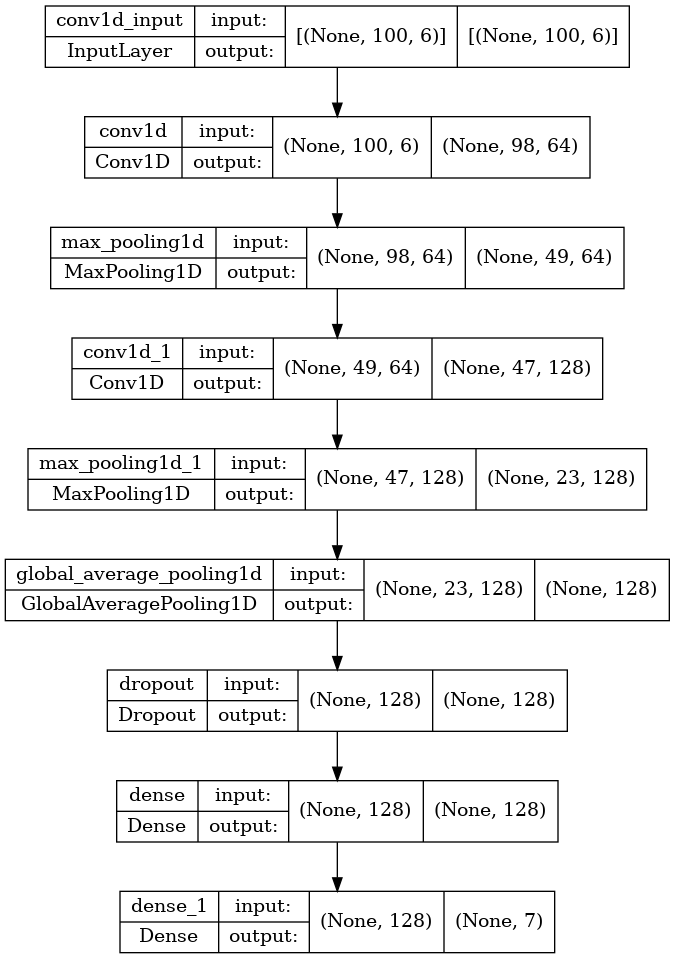

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='{}/model_{}.png'.format(outDir, ttl1), show_shapes=True)

from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, ttl1))

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# dataset 구분하는 마지막 column은 제거

if np.shape(trainX)[-1] == 7:
    trainX = trainX[:,:,:6]
    testX = testX[:,:,:6]

In [29]:
to_Train

True

In [30]:
%%time
# fit network
if to_Train:
    verbose = 1
    history = model.fit(trainX, trainy, epochs=training_epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy)) #,  callbacks=callbacks)
    model.save(fnmodel)
    print('Saved model..... {}'.format(fnmodel))
else:
    model = load_model(fnmodel)
    print('Loaded model..... {}'.format(fnmodel))

Epoch 1/100
498/498 [==============================] - 3s 4ms/step - loss: 0.8573 - accuracy: 0.6426 - val_loss: 0.5723 - val_accuracy: 0.7880
Epoch 2/100
498/498 [==============================] - 2s 4ms/step - loss: 0.5428 - accuracy: 0.7935 - val_loss: 0.4421 - val_accuracy: 0.8603
Epoch 3/100
498/498 [==============================] - 2s 4ms/step - loss: 0.4038 - accuracy: 0.8633 - val_loss: 0.3157 - val_accuracy: 0.8689
Epoch 4/100
498/498 [==============================] - 2s 4ms/step - loss: 0.3117 - accuracy: 0.9026 - val_loss: 0.2515 - val_accuracy: 0.9208
Epoch 5/100
498/498 [==============================] - 2s 4ms/step - loss: 0.2526 - accuracy: 0.9209 - val_loss: 0.2076 - val_accuracy: 0.9378
Epoch 6/100
498/498 [==============================] - 2s 4ms/step - loss: 0.2195 - accuracy: 0.9311 - val_loss: 0.2010 - val_accuracy: 0.9333
Epoch 7/100
498/498 [==============================] - 2s 4ms/step - loss: 0.2034 - accuracy: 0.9344 - val_loss: 0.1826 - val_accuracy: 0.9378

Epoch 58/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0566 - accuracy: 0.9808 - val_loss: 0.1013 - val_accuracy: 0.9715
Epoch 59/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0565 - accuracy: 0.9799 - val_loss: 0.1085 - val_accuracy: 0.9677
Epoch 60/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0598 - accuracy: 0.9805 - val_loss: 0.0974 - val_accuracy: 0.9723
Epoch 61/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0549 - accuracy: 0.9822 - val_loss: 0.1063 - val_accuracy: 0.9697
Epoch 62/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0500 - accuracy: 0.9824 - val_loss: 0.1019 - val_accuracy: 0.9725
Epoch 63/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 0.1050 - val_accuracy: 0.9703
Epoch 64/100
498/498 [==============================] - 2s 4ms/step - loss: 0.0569 - accuracy: 0.9807 - val_loss: 0.1055 - val_accuracy:

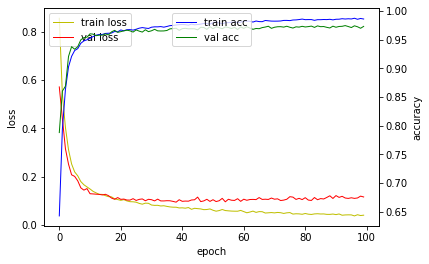

In [31]:
if to_Train:
    key_acc = 'accuracy'
    key_acc_val = 'val_accuracy'

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=1)
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history[key_acc], 'b', label='train acc', linewidth=1)
    acc_ax.plot(history.history[key_acc_val], 'g', label='val acc', linewidth=1)
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')

## 결과

In [32]:
trainX.shape, trainy.shape

((31851, 100, 6), (31851, 7))

In [33]:
pred_train = model.predict(trainX, verbose=1)
pred_test = model.predict(testX, verbose=1)

250/250 [==============================] - 0s 1ms/step


In [34]:
trainy1 = np.argmax(trainy, axis=1)
pred_train1 = np.argmax(pred_train, axis=1)

In [35]:
testy1 = np.argmax(testy, axis=1)
pred_test1 = np.argmax(pred_test, axis=1)

In [36]:
from sklearn.metrics import classification_report
print(cellName[celltype],'Train result')
print(classification_report(trainy1, pred_train1, digits=4))   #classification_report( y_true , y_pred)

Conv1D Train result
              precision    recall  f1-score   support

           0     0.9998    0.9973    0.9985      5830
           1     0.9848    0.9930    0.9889      6668
           2     0.9920    0.9923    0.9921      6588
           3     0.9966    0.9927    0.9946      3552
           4     0.9954    0.9920    0.9937      3250
           5     0.9962    0.9944    0.9953      3924
           6     1.0000    0.9951    0.9975      2039

    accuracy                         0.9938     31851
   macro avg     0.9950    0.9938    0.9944     31851
weighted avg     0.9938    0.9938    0.9938     31851



In [37]:
print(cellName[celltype],'Test result')
print(classification_report(testy1, pred_test1, digits=4))

Conv1D Test result
              precision    recall  f1-score   support

           0     0.9869    0.9774    0.9821      1459
           1     0.9667    0.9743    0.9705      1670
           2     0.9804    0.9715    0.9759      1649
           3     0.9619    0.9640    0.9630       890
           4     0.9382    0.9681    0.9529       815
           5     0.9867    0.9817    0.9842       982
           6     0.9841    0.9706    0.9773       511

    accuracy                         0.9732      7976
   macro avg     0.9721    0.9725    0.9723      7976
weighted avg     0.9734    0.9732    0.9732      7976



In [38]:
# 모델 평가
print(model.metrics_names)
score0 = model.evaluate(trainX, trainy, verbose=1)
score = model.evaluate(testX, testy, verbose=1)

print('Train accuracy:', score0[1])
print('Test accuracy:', score[1])

['loss', 'accuracy']
250/250 [==============================] - 1s 2ms/step - loss: 0.1156 - accuracy: 0.9732
Train accuracy: 0.9937835335731506
Test accuracy: 0.9731695055961609


In [39]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score

# 'micro', 'macro', 'weighted'

f1 = f1_score(trainy1, pred_train1, average='macro')
f11 = f1_score(testy1, pred_test1, average='macro')

print('Train f1-score: ',f1)
print('Test f1-score: ',f11)

Train f1-score:  0.9943808979807232
Test f1-score:  0.9722687891991592


In [40]:
conf_matrix = pd.crosstab(trainy1, pred_train1) #행(row)이 정답, 열(col)이 맞춘거
print(conf_matrix)

col_0     0     1     2     3     4     5     6
row_0                                          
0      5814    10     0     5     1     0     0
1         0  6621    42     0     2     3     0
2         0    46  6537     0     1     4     0
3         1    17     0  3526     8     0     0
4         0    13     4     4  3224     5     0
5         0    12     4     3     3  3902     0
6         0     4     3     0     0     3  2029


In [41]:
conf_matrix = pd.crosstab(testy1, pred_test1) 
print(conf_matrix)

col_0     0     1     2    3    4    5    6
row_0                                      
0      1426     1     1   11   18    0    2
1         2  1627    26    5    4    6    0
2         1    32  1602    2    6    5    1
3         7     7     0  858   15    0    3
4         7     6     1   11  789    0    1
5         1     7     2    3    4  964    1
6         1     3     2    2    5    2  496


In [42]:
outdir = ''
ttl1fn = '{}_'.format(cell_name)
ttl1fn = ttl1fn.replace(' ', '')
print(ttl1fn)

Conv1D_


In [43]:
def plot_confusion_matrix3x(actual, predicted, classes, title='Confusion Matrix', normalize=False, hide_classname = False, 
                            figsize=(4, 4), dpi=36, cmap=plt.cm.viridis, outdir=outDir):
    import itertools
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if not normalize:
        conf_matrix = pd.crosstab(actual, predicted) 
    else:
        conf_matrix = pd.crosstab(actual, predicted).apply(lambda r: r / r.sum(), axis=1)
        
    if np.shape(conf_matrix) != (len(classes), len(classes)):
        print(np.shape(conf_matrix))
        for i in range(len(classes)):
            if i not in conf_matrix.columns:
                conf_matrix[i] = 0.00
        conf_matrix = conf_matrix[[i for i in range(len(classes))]]

    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    ax = plt.gca()
    im = ax.imshow(conf_matrix, aspect=1.0, interpolation='nearest',cmap=cmap)
    
    plt.title(title, size=12)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05, aspect=20)
    plt.colorbar(im, cax=cax)
    
    
    if hide_classname:
        classes2 = []
        for k, _ in enumerate(classes):
            classes2.append('C{}'.format(k))
        classes = classes2
    
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=9) 
    ax.set_xticklabels(classes, fontsize=9, rotation=90)
    
   
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    thresh = 0.5
    
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        if conf_matrix[j][i] > thresh: #thresh[j]:
            color="white" 
        
        else :
            color = "black"  
        ax.text(j, i, format(conf_matrix[j][i], fmt), ha="center", va="center", color=color, fontsize=12)  #14  
        
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.grid(False)
    plt.savefig('{}/final_{}.png'.format(outdir, title), bbox_inches='tight')
    
    return fig

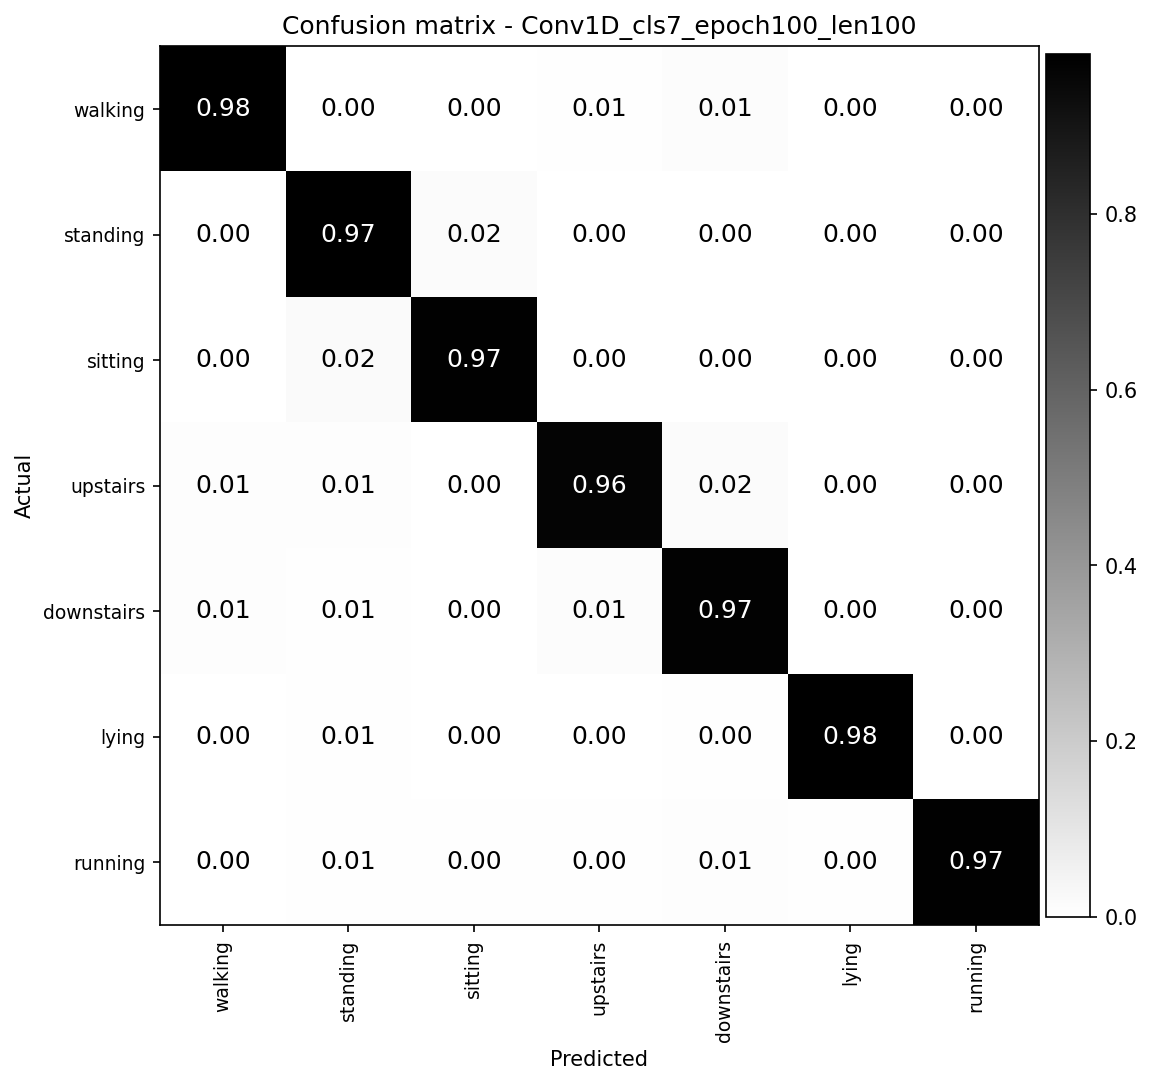

In [44]:
fig_conf = plot_confusion_matrix3x(testy1, pred_test1, class_name, title='Confusion matrix - {}'.format(ttl1), normalize=True,
                                   figsize=(8,8), dpi=150, hide_classname = False, outdir=outDir, cmap = 'binary')

## t-SNE

In [45]:
from sklearn.manifold import TSNE

In [46]:
emb_model = Model(model.input, model.layers[-2].output)
emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_input (InputLayer)   [(None, 100, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 128)              0     

In [47]:
embedding = emb_model.predict(testX)
print(embedding.shape)

(7976, 128)


In [48]:
%%time
proj = TSNE(n_components=2).fit_transform(embedding)

CPU times: user 2min 21s, sys: 21.2 s, total: 2min 43s
Wall time: 14.6 s


In [49]:
cmp = plt.get_cmap("tab20")  #tab10

100%|██████████| 7/7 [00:00<00:00, 271.71it/s]

./out/Conv1D_cls7_epoch100_len100/embedding_Conv1D_cls7_epoch100_len100.png


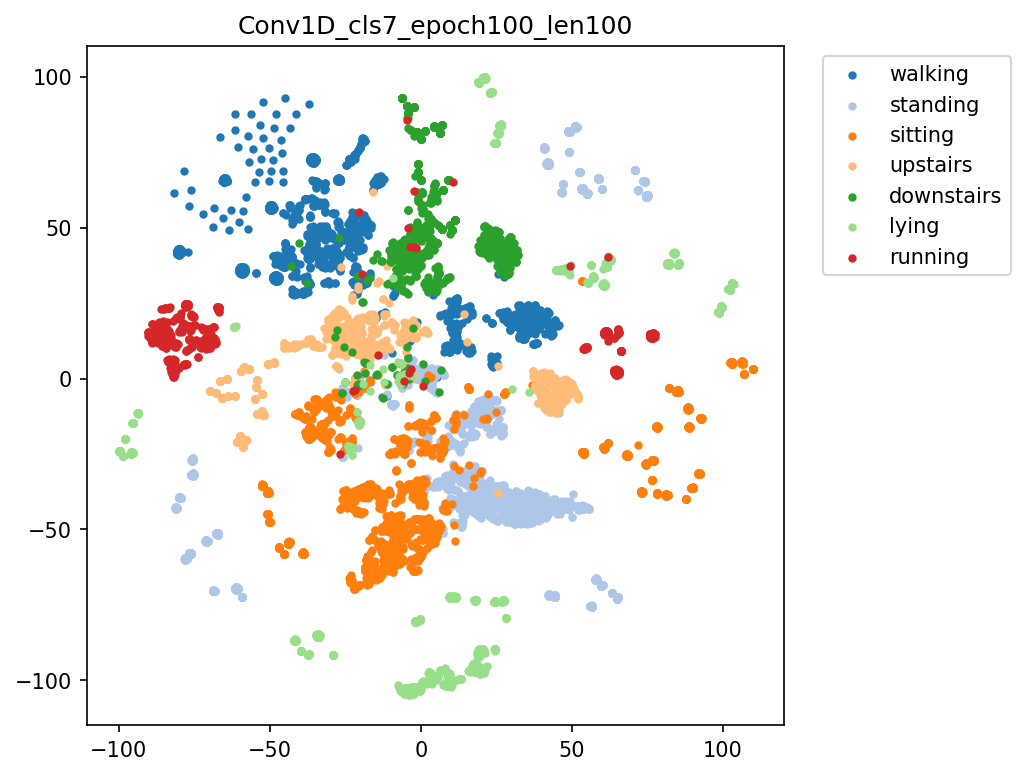

In [50]:
plt.figure(figsize=(6,6), dpi=150)

for i in tqdm(range(n_classes)):
    select_flag = testy1 == i
    plt_latent = proj[select_flag, :]
    plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp(i), marker=".")
fnfig = "{}/embedding_{}.png".format(outDir, ttl1)
print(fnfig)
plt.title(ttl1)
plt.gca().legend(class_name, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(fnfig, bbox_inches = "tight")